In [1]:
%pip install --upgrade tdmclient
%pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import warnings
import time

import numpy as np
import cv2
import math
import matplotlib
import matplotlib.pyplot as plt
import heapq

In [26]:
# GLOBAL VARIABLES ------------------------------------------------

# Geometrical parameters
wheel_spacing = 10e-2 # wheel spacing [m]

# Functions for communication with the Thymio

In [27]:
import tdmclient.notebook
await tdmclient.notebook.start()

NodeLockError: Node lock error (current status: busy)

In [ ]:
@tdmclient.notebook.sync_var
def apply_motor_commands(v_r,v_l):
  # Applies the commands v_l and v_r to the Thymio's motors
  # Inputs : v_r (int), v_l (int)
  # Outputs: None

  global motor_left_target, motor_right_target
  motor_left_target = v_l
  motor_right_target = v_r

@tdmclient.notebook.sync_var
def stop_Thymio():
  # Stops the Thymio robot

  global motor_left_target,motor_right_target
  motor_left_target = 0
  motor_right_target = 0

@tdmclient.notebook.sync_var
def get_motor_speeds():
  # Returns the speeds of the motors : motor.left.speed and motor.right.speed variables from the Thymio
  # Outputs : left_motor_speed (int), right_motor_speed (int)

  global motor_left_speed, motor_right_speed
  return motor_right_speed, motor_left_speed

@tdmclient.notebook.sync_var
def get_prox_sensors():
  # Returns the values of the proximity sensors of the Thymio in a list. Indices [0-4] correspond to the front facing ones (indexed from left to right) and [5-6] are the backwards facing sensors
  # Outputs : prox_horizontal (list of ints of length 7)

  global prox_horizontal
  return prox_horizontal

# Helper functions

In [ ]:
def convert_speed_to_tymio_int(v_speed):
  if np.abs(v_speed) > 20e-2:
    print('Demanded speed is outside Thymio range and has been capped')
    return int(np.sign(v_speed) * 500)
  else:
    return int(np.sign(v_speed) * np.floor(np.abs(v_speed) * 500 / (20e-2)))

def convert_thymio_int_to_speed(motor_int):
  return motor_int * 20e-2 / 500

def clamp(val):
  print('Demanded speed is outside Thymio range and has been capped')
  return max(min(int(val), 500), -500)

def camera_to_world(frame_size,xy,theta):
  return [xy[0], frame_size[1] - xy[1]], -theta

# Computer vision

In [ ]:
# COMPUTER VISION VARIABLES ----------------------------------------

# Real-world coordinates of the 8 corners of the aruco markers
# Order must match the corner order from ArUco: TL, TR, BR, BL.
# Top-left marker
pts_world_TL = np.array([
    [-6.5, -6.5],   # top-left
    [ 0.0, -6.5],   # top-right
    [ 0.0,  0.0],   # bottom-right
    [-6.5,  0.0],   # bottom-left
], dtype=np.float32)

# Top-right marker
pts_world_TR = np.array([
    [77.0, -6.5],   # top-left
    [83.5, -6.5],   # top-right
    [83.5,  0.0],   # bottom-right
    [77.0,  0.0],   # bottom-left
], dtype=np.float32)

# Bottom-right marker
pts_world_BR = np.array([
    [77.0, 71.0],   # top-left
    [83.5, 71.0],   # top-right
    [83.5, 77.5],   # bottom-right
    [77.0, 77.5],   # bottom-left
], dtype=np.float32)

# Bottom-left marker
pts_world_BL = np.array([
    [-6.5, 71.0],   # top-left
    [0.0, 71.0],   # top-right
    [0.0, 77.5],   # bottom-right
    [-6.5, 77.5],   # bottom-left
], dtype=np.float32)

pts_world = np.vstack([pts_world_TL,pts_world_TR, pts_world_BR,pts_world_BL])     # shape (8,2)

frame_size = [77.0e-2,71.0e-2]

# ArUco dictionary (DICT_4X4_50)
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
aruco_params = cv2.aruco.DetectorParameters()

In [ ]:
# COMPUTER VISION HELPER FUNCTIONS ----------------------------------------

# Compute center of the ArUco marker
def compute_center(top_left,bottom_right):
    center_x = int((top_left[0] + bottom_right[0]) / 2.0)
    center_y = int((top_left[1] + bottom_right[1]) / 2.0)
    return center_x,center_y

# Compute angle of vector = (bottom_left -> top_left) w.r.t horizontal axis
def compute_angle(top_left,bottom_left):
    x_diff = int(top_left[0] - bottom_left[0])
    y_diff = int(top_left[1] - bottom_left[1])
    return math.atan2(y_diff,x_diff)

def detect_red_polygons(frame,
                        min_area=300,       # filter tiny blobs
                        eps_factor=0.02):   # approximation factor for vertices
    """
    Returns:
      polygons: list of (N,2) int arrays with polygon vertices in image coords
      mask: binary mask used to detect red regions
    """
    # BGR -> HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Red wraps around 0°, so use two ranges
    lower_red1 = np.array([0,   80,  80])
    upper_red1 = np.array([10,  255, 255])
    lower_red2 = np.array([170, 80,  80])
    upper_red2 = np.array([180, 255, 255])

    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask  = cv2.bitwise_or(mask1, mask2)

    # Cleanup (optional but usually helpful)
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=2)

    # Contours --> polygons
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue

        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, eps_factor * peri, True)  # (N,1,2)
        verts = approx.reshape(-1, 2)                            # (N,2)
        polygons.append(verts.astype(int))

    return polygons, mask

def detect_red_polygons_in_map(frame, p_tl, p_br,min_area=300, eps_factor=0.02):
    x0, y0 = p_tl
    x1, y1 = p_br

    # Ensure proper ordering
    x0, x1 = sorted((x0, x1))
    y0, y1 = sorted((y0, y1))

    roi = frame[y0:y1, x0:x1]

    polygons_roi, mask_roi = detect_red_polygons(roi,min_area=min_area,eps_factor=eps_factor)
    # Shift vertices back to full-frame coordinates
    polygons_full = []
    offset = np.array([[x0, y0]])
    for verts in polygons_roi:
        polygons_full.append(verts + offset)

    #return polygons_full, mask_roi
    return polygons_full

# map a single image point (u,v) to world (X,Y)
def img_to_world(u,v,H):
    uv1 = np.array([u,v, 1.0], dtype=np.float32) # z = 1
    XY1 = H @ uv1
    XY1 /= XY1[2]  # scale back to world coordinates where z = 1
    return float(XY1[0]), float(XY1[1])

# helper function to display text
def putText(frame, text, x, y):
    cv2.putText(frame,str(text),(int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0, 100, 150),2)

def draw_global_path(frame, H, global_path):
    if global_path is None or global_path.shape[1] < 2:
        return

    # If H maps image -> world, then inv(H) maps world -> image
    try:
        Hinv = np.linalg.inv(H)
    except np.linalg.LinAlgError:
        return  # H not invertible

    # global_path is 2xN (x_world, y_world). Convert to Nx1x2 for OpenCV.
    pts_world = global_path[:2, :].T.astype(np.float32).reshape(-1, 1, 2)

    # Map world -> image using Hinv
    pts_img = cv2.perspectiveTransform(pts_world, Hinv).reshape(-1, 2)

    # Draw polyline
    for p1, p2 in zip(pts_img[:-1], pts_img[1:]):
        if not (np.isfinite(p1).all() and np.isfinite(p2).all()):
            continue
        x1, y1 = map(int, np.round(p1))
        x2, y2 = map(int, np.round(p2))
        cv2.line(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)


In [ ]:
# COMPUTER VISION GLOBAL FUNCTIONS ----------------------------------------

def get_camera_measurement(frame, only_thymio=False, plot_view=False):
    """
    Returns:
        thymio_x, thymio_y, thymio_theta: position (x,y) in m and orientation theta in radians
    If only_thymio is False then in addition to above returns:
        goal_x, goal_y: position (x,y) in m
        list of (N,2) int arrays with polygon vertices in world coords
    """
    # Convert to grayscale (Aruco works on grayscale)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # gray is an array of shape (height, width, 1) type uint8

    # Detect markers
    corners, ids, _ = cv2.aruco.detectMarkers(gray, aruco_dict, parameters=aruco_params)

    # Initialize outputs
    thymio_start = np.array([1e8,1e8])
    thymio_theta = 0
    goal = polygons_real_world = H = None

    # ---------------- Marker detection and map definition ----------------
    if len(ids) >= 6: # all markers must be detected

        # 0: TL, 1: TR, 2: BR, 3: BL, 4: thymio, 5: goal
        marker0_TL = marker1_TR = marker2_BR = marker3_BL = marker4_thymio = marker5_goal = 0

        ids_flat = ids.flatten()
        for i, marker_id in enumerate(ids_flat):
            if marker_id == 0:
                marker0_TL = i
            elif marker_id == 1:
                marker1_TR = i
            elif marker_id == 2:
                marker2_BR = i
            elif marker_id == 3:
                marker3_BL = i
            elif marker_id == 4:
                marker4_thymio = i
            elif marker_id == 5:
                marker5_goal = i

        # Interior corner of each map marker (assuming OpenCV order TL=0, TR=1, BR=2, BL=3)
        tl_pt = corners[marker0_TL][0][2]  # BR of TL marker (closest to map interior)
        tr_pt = corners[marker1_TR][0][3]  # BL of TR marker
        br_pt = corners[marker2_BR][0][0]  # TL of BR marker
        bl_pt = corners[marker3_BL][0][1]  # TR of BL marker

        # Four corners of the virtual map (axis aligned)
        p_tl = (int(tl_pt[0]), int(tl_pt[1]))
        p_br = (int(br_pt[0]), int(br_pt[1]))
        p_tr = (int(tr_pt[0]), int(tr_pt[1]))
        p_bl = (int(bl_pt[0]), int(bl_pt[1]))

        # ---------------- Position/orientation of thymio and goal in image space ----------------
        thymio_x_img, thymio_y_img = compute_center(
            corners[marker4_thymio][0][0],  # TL
            corners[marker4_thymio][0][2]   # BR
        )
        goal_x_img, goal_y_img = compute_center(
            corners[marker5_goal][0][0],    # TL
            corners[marker5_goal][0][2]     # BR
        )
        thymio_theta = compute_angle(
            corners[marker4_thymio][0][0],  # TL
            corners[marker4_thymio][0][3]   # BL
        )

        # ---------------- Homography: image -> world ----------------
        # Image/pixel coordinates of the 16 corners (4 markers × 4 corners)
        pts_img_TL = corners[marker0_TL][0].astype(np.float32)  # (4,2)
        pts_img_TR = corners[marker1_TR][0].astype(np.float32)  # (4,2)
        pts_img_BR = corners[marker2_BR][0].astype(np.float32)  # (4,2)
        pts_img_BL = corners[marker3_BL][0].astype(np.float32)  # (4,2)

        pts_img = np.vstack([pts_img_TL, pts_img_TR, pts_img_BR, pts_img_BL]).astype(np.float32)  # (16,2)

        # Homography matrix (pts_world must be shape (16,2), matching the order above)
        H, inliers = cv2.findHomography(pts_img, pts_world)  # method=0: DLT

        # Compute position of thymio / goal / obstacles in real world (origin at top left corner of map)
        thymio_x, thymio_y = img_to_world(thymio_x_img, thymio_y_img, H)
        thymio_start = np.array([thymio_x, thymio_y])


        if(not only_thymio):
            goal_x, goal_y = img_to_world(goal_x_img, goal_y_img, H)
            goal = np.array([goal_x, goal_y])

            polygons_img_world = detect_red_polygons_in_map(frame, p_tl, p_br)

            polygons_real_world = []
            # Map polygon vertices to real world positions
            for verts in polygons_img_world:  # verts: (N,2) in image coords
                cnt = verts.reshape(-1, 1, 2).astype(np.float32)    # cv2 uses (N,1,2) format
                cnt_world = cv2.perspectiveTransform(cnt, H)        # same as img_to_world but batched
                polygons_real_world.append(cnt_world.reshape(-1, 2) * 1e-2)  # list of (N,2) world coords
            #print(polygons_real_world)
            #polygons_real_world = np.array(polygons_real_world)  # (M,N,2) where M is the number of polygons

        if plot_view:
          #  ---------------- Display Map,Thymio,Goal,Polygons ----------------

          # Draw virtual map
          cv2.line(frame, p_tl, p_tr, (0, 0, 0), 2)
          cv2.line(frame, p_tr, p_br, (0, 0, 0), 2)
          cv2.line(frame, p_br, p_bl, (0, 0, 0), 2)
          cv2.line(frame, p_bl, p_tl, (0, 0, 0), 2)

          cv2.aruco.drawDetectedMarkers(frame, corners, ids)

          # # Thymio position / angle
          putText(frame, f"{thymio_theta:.2f}", thymio_x_img, thymio_y_img)
          putText(frame, f"({thymio_x:.2f}, {thymio_y:.2f})",thymio_x_img, thymio_y_img + 15)  # +15 to move a bit down

          if(not only_thymio):
              # Display Goal position
              #putText(frame, f"({goal_x:.2f}, {goal_y:.2f})", goal_x_img, goal_y_img)

              # Display detected polygons in image space
              for verts in polygons_img_world:
                  cv2.polylines(frame, [verts], True, (255, 0, 255), 2)  # connect vertices
                  for (x, y) in verts: #  verts is (N,2) where N is the number of vertices in a polygon
                      cv2.circle(frame, (int(x), int(y)), 4, (0, 0, 255), -1)  # circle at each vertex

    if only_thymio:
        return thymio_start * 1e-2, thymio_theta
    else:
        return thymio_start * 1e-2, thymio_theta, goal * 1e-2, polygons_real_world, H

# Kalman filter

In [28]:
# KALMAN FILTER VARIABLES ----------------------------------------

dt = 0.1 # time between EKF calls [s]
alpha = 0 # linear gain in uncertainty
threshold = 11 # cutoff of the Mahalanobis distance for measurement outlier rejection

var_v_l = 1e-2 # variance in the left wheel linear speed measurements [m2/s2]
var_v_r = 1e-2 # variance in the right wheel linear speed measurements [m2/s2]

var_x_cam = 1e-4 # variance in the x coordinate camera measurement [m2]
var_y_cam = 1e-4 # variance in the y coordinate camera measurement [m2]
var_theta_cam = 1e-2 # variance in the heading camera measurement [rad2]

In [29]:
# KALMAN FILTER HELPER FUNCTIONS ----------------------------------------

def motion_model(X,U,dt):
  # Returns the next pose of the Tymio robot predicted by the motion model for an inital pose X = [x[m],y[m],theta[rad]], a control U = [v_r[m/s],v_l[m/s]] and a time step dt
  # Inputs: X (3x1 numpy array), U (2x1 numpy array), dt (positive float)
  # Outputs : X+ (3x1 numpy array)

  x = X[0]
  y = X[1]
  theta = X[2]
  v_r = U[0]
  v_l = U[1]

  x_plus = x + (v_r+v_l)/2 * np.cos(theta) * dt
  y_plus = y + (v_r+v_l)/2 * np.sin(theta) * dt
  theta_plus = theta + (v_r-v_l)/wheel_spacing * dt

  return np.array([x_plus,y_plus,theta_plus]).T

def estimate_next_pose(X_meas,P,U_sens,dt):
  # Returns the next pose of the Tymio robot predicted by the motion model for a measured pose X_meas = [x[m],y[m],theta[rad]], a sensor value for the control input U_sens = [v_r[int],v_l[int]] and a time step dt
  # as well as the uncertainty associated with this estimation
  # Inputs: X_meas (3x1 numpy array), P (3x3 numpy array), U_sens (2x1 numpy array), dt (positive float)
  # Outputs : X_estim (3x1 numpy array), P_estim (3x3 numpy array)

  x = X_meas[0]
  y = X_meas[1]
  theta = X_meas[2]
  v_r = convert_thymio_int_to_speed(U_sens[0])
  v_l = convert_thymio_int_to_speed(U_sens[1])

  X_estim = motion_model(X_meas,np.array([v_r,v_l]).T,dt)

  J = np.array([[1,0,-(v_r+v_l)/2 * np.sin(theta) * dt],[0,1,(v_r+v_l)/2 * np.cos(theta) * dt],[0,0,1]])
  G = np.array([[0.5*np.cos(theta),0.52*np.cos(theta)],[0.5*np.sin(theta),0.5*np.sin(theta)],[dt/wheel_spacing, -dt/wheel_spacing]])

  Q = G @ np.array([[var_v_r,0],[0,var_v_l]]) @ G.T + alpha * np.eye(3)

  P_estim = J @ P @ J.T + Q

  return X_estim, P_estim

def correct_estimation(X_estim,P_estim,Z_meas):
  # Returns the corrected pose of the Tymio robot (based on the EKF) based on the estimated pose (given by the control model) X_estim = [x[m],y[m],theta[rad]], and the measured pose Z_meas = [x_cam[m],y_cam[m],theta_cam[rad]]
  # as well as the uncertainty associated with this corrected position
  # Inputs: X_estim (3x1 numpy array), P_estim (3x3 numpy array), Z_meas (3x1 numpy array)
  # Outputs : X_corr (3x1 numpy array), P_corr (3x3 numpy array)

  Y = Z_meas - X_estim # compute the residual
  Y[2] = (Y[2] + np.pi) % (2*np.pi) - np.pi # wrap the residual angle to ]-pi,pi]

  S = P_estim + np.array([[var_x_cam,0,0],[0,var_y_cam,0],[0,0,var_theta_cam]])
  S_inv = np.linalg.inv(S)

  # compute Mahalanobis distance and abort correction step if the measurement is rejected
  if Y.T @ S_inv @ Y > threshold:
    print('Measurement rejected')
    return X_estim, P_estim

  K = P_estim @ S_inv

  X_corr = X_estim + K @ Y
  P_corr = (np.eye(3) - K) @ P_estim

  return X_corr, P_corr

In [30]:
# KALMAN FILTER GLOBAL FUNCTIONS ----------------------------------------

def update_robot_pose_EKF(X_old, P_old, frame):
  # Returns the updated state vector X = [x, y, theta].T of the robot pose using the Kalman filter (combines motor speeds with camera measurements (frame variable is the camera frame))
  # Inputs : X_old (3x1 numpy array), P_old (3x3 numpy array), frame (image_heightximage_widthx3 numpy array of uint8s)
  # Outputs : X (3x1 numpy array), P (3x3 numpy array)

  v_r, v_l = get_motor_speeds()
  U_sens = np.array([v_r, v_l]).T

  X_estim, P_estim = estimate_next_pose(X_old, P_old, U_sens, dt) # estimation step

  xy_cam, theta_cam = get_camera_measurement(frame,only_thymio=True)
  xy_cam, theta_cam = camera_to_world(frame_size, xy_cam, theta_cam)

  Z_meas = np.array([xy_cam[0], xy_cam[1], theta_cam]).T

  X, P = correct_estimation(X_estim, P_estim, Z_meas) # correction step

  return X, P

# Path planning

In [31]:
# PATH PLANNING VARIABLES ----------------------------------------

scale_factor = 1.7  # 1.7x bigger obstacles

In [32]:
# PATH PLANNING HELPER FUNCTIONS ----------------------------------------

def build_poly_edges(polygons):
    poly_edges = []
    for verts in polygons:
        n = len(verts)
        edges_for_poly = []
        for i in range(n):
            x1, y1 = verts[i]
            x2, y2 = verts[(i + 1) % n]   # wrap-around
            edges_for_poly.append([x1, y1, x2, y2])
        poly_edges.append(edges_for_poly)
    return poly_edges

def offset_polygon(vertices, L):
    """
    Agrandit un polygone CCW d'un offset L vers l'extérieur.
    
    vertices : liste de (x, y)
    L        : distance d'offset
    retourne : nouvelle liste de sommets (x, y)
    """
    V = np.asarray(vertices, dtype=float)
    n = len(V)
    out = []

    for i in range(n):
        p_prev = V[(i - 1) % n]
        p_curr = V[i]
        p_next = V[(i + 1) % n]

        # Vecteurs des 2 arêtes autour de p_curr
        e1 = p_curr - p_prev
        e2 = p_next - p_curr

        n1 = np.linalg.norm(e1)
        n2 = np.linalg.norm(e2)
        if n1 < 1e-12 or n2 < 1e-12:
            # Cas dégénéré : on recopie tel quel
            out.append(tuple(p_curr))
            continue

        t1 = e1 / n1  # direction de l'arête (p_prev -> p_curr)
        t2 = e2 / n2  # direction de l'arête (p_curr -> p_next)

        # Normales extérieures pour un polygone CCW (droite de la direction)
        n_1 = np.array([t1[1], -t1[0]])
        n_2 = np.array([t2[1], -t2[0]])

        # Points sur les droites offsetées
        Q1 = p_curr + L * n_1
        Q2 = p_curr + L * n_2

        # Résoudre Q1 + s*t1 = Q2 + t*t2
        A = np.column_stack((t1, -t2))
        b = Q2 - Q1

        try:
            s, _ = np.linalg.solve(A, b)
            new_pt = Q1 + s * t1
        except np.linalg.LinAlgError:
            # Arêtes quasi-parallèles : on moyenne les normales
            n_avg = n_1 + n_2
            if np.linalg.norm(n_avg) < 1e-12:
                n_avg = n_1
            n_avg = n_avg / np.linalg.norm(n_avg)
            new_pt = p_curr + L * n_avg

        out.append(new_pt)

    return np.array(out)

def inflate_object(polygon, scale):
    """
    Uniformly scales a polygon around its centroid.

    polygon : (N, 2) ndarray  (vertices in order)
    scale   : float > 1       (how much larger you want it)

    returns : (N, 2) ndarray of inflated vertices
    """
    poly = np.asarray(polygon, dtype=float)
    center = poly.mean(axis=0)          # centroid
    #inflated = center + scale * (poly - center)
    inflated = center + scale * (poly - center)

    return inflated

# -------------------- Geometry helpers --------------------

def point_on_segment(px, py, x1, y1, x2, y2, eps=1e-9):
    # check if P is on segment [P1,P2]
    vx, vy = x2 - x1, y2 - y1
    wx, wy = px - x1, py - y1

    # cross product == 0  -> colinear
    if abs(vx * wy - vy * wx) > eps:
        return False

    # dot product between 0 and |v|^2 -> within segment bounds
    dot = vx * wx + vy * wy
    if dot < -eps:
        return False

    v2 = vx * vx + vy * vy
    if dot > v2 + eps:
        return False

    return True


def point_in_polygon_strict(point, verts, eps=1e-9):
    """
    True if point is strictly inside polygon (not on boundary).
    verts: (N,2) array.
    """
    x, y = point

    # 1) boundary check: if on any edge -> not strictly inside
    n = len(verts)
    for i in range(n):
        x1, y1 = verts[i]
        x2, y2 = verts[(i + 1) % n]
        if point_on_segment(x, y, x1, y1, x2, y2, eps):
            return False

    # 2) standard ray-casting for inside
    inside = False
    j = n - 1
    for i in range(n):
        xi, yi = verts[i]
        xj, yj = verts[j]
        # edge crosses horizontal ray?
        if ((yi > y) != (yj > y)):
            x_int = xi + (xj - xi) * (y - yi) / (yj - yi)
            if x < x_int:
                inside = not inside
        j = i
    return inside


def segment_intersection_params(e1, e2, eps=1e-9):
    """
    Return (t, s) if segments e1 and e2 intersect, else None.
    e1, e2 are [x1, y1, x2, y2].
    t is parameter on e1, s on e2.
    """
    x1, y1, x2, y2 = e1
    x3, y3, x4, y4 = e2

    dx1, dy1 = x2 - x1, y2 - y1
    dx2, dy2 = x4 - x3, y4 - y3

    A = np.array([[dx1, -dx2],
                  [dy1, -dy2]], dtype=float)
    b = np.array([x3 - x1,
                  y3 - y1], dtype=float)

    det = np.linalg.det(A)
    if abs(det) < eps:
        # parallel / colinear: ignore for visibility test
        return None

    t, s = np.linalg.solve(A, b)

    if -eps <= t <= 1.0 + eps and -eps <= s <= 1.0 + eps:
        return t, s
    return None

def all_intersections_on_candidate(candidate, obstacle_edges, eps=1e-6):
    """
    Return list of unique t in [0,1] where candidate intersects any obstacle edge.
    """
    ts = []
    for e in obstacle_edges:
        res = segment_intersection_params(candidate, e)
        if res is None:
            continue
        t, s = res

        # snap to exact endpoints if very close
        if abs(t) < eps:
            t = 0.0
        elif abs(t - 1.0) < eps:
            t = 1.0

        # deduplicate by t
        if not any(abs(t - t0) < eps for t0 in ts):
            ts.append(t)
    return ts

def is_valid_visibility_edge(candidate, obstacle_edges, polygons, eps=1e-6):
    """
    Edge is valid if:
      - its interior does not intersect any obstacle edge, AND
      - its interior does not lie inside any polygon.
    Intersections at endpoints are allowed.
    """
    # 1) boundary intersections (same as before)
    ts = all_intersections_on_candidate(candidate, obstacle_edges, eps)
    for t in ts:
        if eps < t < 1.0 - eps:   # interior intersection with boundary
            return False

    # 2) interior point inside any polygon?
    x1, y1, x2, y2 = candidate
    mx, my = (x1 + x2) / 2.0, (y1 + y2) / 2.0   # midpoint

    for poly in polygons:
        if point_in_polygon_strict((mx, my), poly, eps):
            return False

    return True

# -------------------- Dijkstra --------------------
def dijkstra(adj, start_idx, goal_idx):
    n = len(adj)
    INF = 1e18
    dist = [INF] * n
    prev = [-1] * n

    dist[start_idx] = 0.0
    pq = [(0.0, start_idx)]

    while pq:
        d, u = heapq.heappop(pq)
        if d > dist[u] + 1e-12:
            continue
        if u == goal_idx:
            break
        for v, w in adj[u]:
            nd = d + w
            if nd < dist[v] - 1e-12:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if dist[goal_idx] >= INF:
        return None, dist

    # reconstruct path
    path = []
    u = goal_idx
    while u != -1:
        path.append(u)
        u = prev[u]
    path.reverse()
    return path, dist

In [33]:
# PATH PLANNING GLOBAL FUNCTIONS ----------------------------------------

def get_objective_waypoints(start, goal, polygons):
  # Returns a list of the coordinates of the N waypoints that the robot much reach from the start coordinates, the goal coordinates and the polygon coordinates vector ()
  # The list is ordered in reverse order of visit of waypoints (ie the goal is the first set of coordinates, then the before last waypoint and so on)
  # Example get_objective_waypoints() = np.array([[x_N,y_N], [x_N-1,y_N-1], ..., [x_1,y_1]])
  # Inputs : start (2x1 numpy array of floats), goal (2x1 numpy array of floats), polygons (Px1 numpy array of numpy array of coordinates)
  # Output : waypoints (list of N arrays of floats)


  #inflated_polygons = [inflate_object(poly, scale_factor) for poly in polygons]

  offset = 0.0 # dont know if we need to pu it in cm
  inflated_polygons = [offset_polygon(poly,offset) for poly in polygons]
  polygons = inflated_polygons

  poly_edges = build_poly_edges(polygons)
  obstacle_edges = [e for poly in poly_edges for e in poly]

  # Nodes: start, goal, and all polygon vertices
  points = [start, goal] + [v for poly in polygons for v in poly]
  n_points = len(points)

  # Build graph
  valid_edges = []            # list of [x1,y1,x2,y2] for plotting
  adj = {i: [] for i in range(n_points)}  # adjacency list

  for i in range(n_points):
      for j in range(i + 1, n_points):
          x1, y1 = points[i]
          x2, y2 = points[j]
          candidate = [x1, y1, x2, y2]

          if is_valid_visibility_edge(candidate, obstacle_edges, polygons):
              valid_edges.append(candidate)
              w = float(np.linalg.norm(np.array(points[i]) - np.array(points[j])))
              adj[i].append((j, w))
              adj[j].append((i, w))

  # -------------------- Shortest path (Dijkstra) --------------------
  start_idx = 0  # start
  goal_idx  = 1  # goal
  path_indices, dist = dijkstra(adj, start_idx, goal_idx)
  print("Shortest distance:", dist[goal_idx])
  print("Path indices:", path_indices)

  objective_waypoints = []

  while len(path_indices) > 1:
    i = path_indices.pop()
    objective_waypoints.append(points[i])

  return objective_waypoints

# Local obstacle avoidance

In [34]:
# LOCAL AVOIDANCE VARIABLES ----------------------------------------

THRESH_ENTRY = 2000
THRESH_WALL_LOST = 150   # Low threshold to keep tracking small obstacles
TARGET_DIST = 2000

# PID Parameters
P_GAIN = 0.25            # Reactive P for small boxes
D_GAIN = 0.5             # D to stop oscillation

BASE_SPEED = 100         # Used ONLY during avoidance
CLEARANCE_STEPS_TARGET = 15

In [35]:
# LOCAL AVOIDANCE HELPER FUNCTIONS ----------------------------------------
def alias_sensors():
  # Returns the aliased sensor values as ints of numpy arrays
  # Outputs : front_all (5x1 numpy array of ints), front_center (int), left_side (int), right_side (int)
  prox_horizontal = get_prox_sensors()

  front_all = np.array(prox_horizontal[0:5])
  front_center = prox_horizontal[2]
  left_side = prox_horizontal[0]
  right_side = prox_horizontal[4]

  return front_all, front_center, left_side, right_side

def left_obstacle_navigation(state, clearance_counter, prev_error, front_center, left_side):
  # Returns the commands v_l and v_r corresponding to the control law for local obstacle avoidance and navigation for obstacles on the left side
  # Inputs : state (str), clearance_counter (int), prev_error (int), front_center (int), left_side (int)
  # Outputs : v_r (int), v_l (int)

  if front_center > THRESH_ENTRY:
    return 100, -100

  # Exit: Wall ended
  if left_side < THRESH_WALL_LOST:
    state = "CLEARANCE"
    clearance_counter = 0
    return BASE_SPEED, BASE_SPEED

  # PD Control
  error = left_side - TARGET_DIST
  derivative = error - prev_error
  correction = int(error * P_GAIN + derivative * D_GAIN)
  prev_error = error

  return clamp(BASE_SPEED + correction), clamp(self.BASE_SPEED - correction)


def right_obstacle_navigation(state, clearance_counter, prev_error, front_center, right_side):
  # Returns the commands v_l and v_r corresponding to the control law for local obstacle avoidance and navigation for obstacles on the right side
  # Inputs : state (str), clearance_counter (int), prev_error (int), front_center (int), right_side (int)
  # Outputs : v_r (int), v_l (int)

  # Safety
  if front_center > THRESH_ENTRY:
    return -100, 100

  # Exit
  if right_side < THRESH_WALL_LOST:
    state = "CLEARANCE"
    clearance_counter = 0
    return BASE_SPEED, BASE_SPEED

  # PD Control
  error = right_side - TARGET_DIST
  derivative = error - prev_error
  correction = int(error * P_GAIN + derivative * D_GAIN)
  prev_error = error

  return clamp(BASE_SPEED - correction), clamp(BASE_SPEED + correction)

In [36]:
# LOCAL AVOIDANCE GLOBAL FUNCTIONS ----------------------------------------

def detect_local_obstacle(state):
  # Returns a bool indicating if a local obstacle is detected and updates the state variable
  # Outputs : obstacle_detected (bool)

  front_all, front_center, left_side, right_side = alias_sensors()

  obstacle_detected = False

  if max(front_all) > THRESH_ENTRY:
    warnings
    warnings.warn("Obstacle detected")
    obstacle_detected = True

    # Decision logic: Go Left or Right?
    sum_left = front_all[0] + front_all[1]
    sum_right = front_all[3] + front_all[4]

    if sum_left > (sum_right + 50):
      state = "FOLLOW_LEFT"
      previous_wall_side = "LEFT"
    else:
      state = "FOLLOW_RIGHT"
      previous_wall_side = "RIGHT"

  return obstacle_detected

def control_local_navigation(state, clearance_counter, previous_wall_side, prev_error):
  # Returns the commands v_l and v_r corresponding to the control law for local obstacle avoidance and navigation
  # Inputs : ??
  # Outputs : v_r (int), v_l (int)

  front_all, front_center, left_side, right_side = alias_sensors()

  if state == "FOLLOW_LEFT":
    return left_obstacle_navigation(front_center, left_side)
  elif state == "FOLLOW_RIGHT":
    return right_obstacle_navigation(front_center, right_side)
  elif state == "CLEARANCE":
      # Check for new obstacles
      if max(front_all) > THRESH_ENTRY:
        print("New obstacle! Back to following.")
        state = f"FOLLOW_{previous_wall_side}"
        return 0, 0

      clearance_counter += 1

      if clearance_counter >= CLEARANCE_STEPS_TARGET:
        print("Clearance complete")
        state = "GLOBAL"
        return 0, 0

      return BASE_SPEED, BASE_SPEED
  else:
    warnings.warn(f"Unknown state : {state}")
    return 0, 0

# Global navigation control

To control the heading of the Thymio robot, we opt for an "optimistic" controller architecture:

* At timestep $i \times N$, where $i \in \mathbb{N}$, we compute the error on the heading : $$ \Delta \theta_{i \times N} = \theta_{des} - \theta_{i \times N}$$ where $\theta_{i \times N}$ is given by the Kalman filter and $\theta_{des}$ is computed geometrically as $\theta_{des} = \arctan{\frac{y_{des}-y_i}{x_{des}-x_i}}$
where $(x_{des},y_{des})$ are the coordinates of the waypoint, $X_k = (x_k, y_k, \theta_k)^T$ is the state space vector of the robot's pose at timestep $k$

* We then "optimistically" aim to correct this error over the $N$ next timesteps by applying a constant **adjusted** command to the motors. Indeed, we apply correction  $\Delta v_{i \times N}^R$ and $\Delta v_{i \times N}^L$ to the commands, and these corrections are given by $\omega_{i \times N} = \frac{\Delta v_{i \times N}^R - \Delta v_{i \times N}^L}{\text{wheel spacing}}$ and $\Delta V_{i \times N} = \frac{\Delta v_{i \times N}^R + \Delta v_{i \times N}^L}{2}$ such that $\theta_{(i+1) \times N} = \theta_{i \times N} + \omega_{i \times N} \times N dt = \theta_{des}$ and $\Delta V_{i \times N} = 0$


Thus the update step yields a new motor command that is to be applied over the next $N$ timesteps :

$$ \begin{cases}
    \Delta v_i^R = \frac{1}{2} \frac{\text{wheel spacing}}{dt} \frac{\Delta \theta_{i \times N}}{N} \\
    \Delta v_i^L = -\Delta v_i^R
  \end{cases} $$

In [37]:
# GLOBAL NAVIGATION VARIABLES ----------------------------------------

N = 100

In [38]:
# GLOBAL NAVIGATION GLOBAL FUNCTIONS ----------------------------------------

def heading_correction_command(X, waypoint,N):
  # Returns the corrections to be applied to the commands v_l and v_r corresponding to the control law above for global navigation, computed from the state vector at time i (X), the waypoint coordinates and the horizon N
  # Inputs : X (3x1 numpy array), waypoint (2x1 numpy array), N (int)
  # Outputs : del_v_r (int), del_v_l (int)

  x = X[0]
  y = X[1]
  theta = X[2]

  x_des = waypoint[0]
  y_des = waypoint[1]
  theta_des = np.arctan2(y_des-y, x_des-x)

  print(theta_des - theta)

  del_v_r = 0.5 * (theta_des - theta) * wheel_spacing / (dt * N)
  del_v_l = - del_v_r

  del_v_r = convert_speed_to_tymio_int(del_v_r)
  del_v_l = convert_speed_to_tymio_int(del_v_l)

  return int(del_v_r), int(del_v_l)

# Motion control

The robots movement between 2 waypoints happens in 3 phases in the case of global navigation :


1.   To begin with, the robot does a pure rotation to align its heading in the direction of the waypoint:
$$V = \frac{v_i^R + v_i^L}{2} = 0 \; \Rightarrow \; \begin{cases}
    v_0^R = 0 \\
    v_0^L = 0
  \end{cases} $$

2.   Once the angle $\theta$ is within an $\varepsilon_\theta$ of $\theta_{des}$, the robot starts moving forwards at a constant speed:
$$V = \frac{v_i^R + v_i^L}{2} = 5 \text{ cm/s} \; \Rightarrow \; \begin{cases}
    v_0^R = 5 \text{ cm/s} \\
    v_0^L = 5 \text{ cm/s}
  \end{cases} $$

3.  Once the robot position $(x,y)$ is within a distance $\varepsilon_d$ of $(x_{des},y_{des})$, the robot stops moving altogether:
$$ \begin{cases}
    v^R = 0 \\
    v^L = 0
  \end{cases} $$

The next waypoint is then selected as the new desired position, and the sequence starts again.

In [39]:
# MOTION CONTROL VARIABLES ----------------------------------------
forward_speed = 2e-2
eps_theta = np.pi/50 # tolerance for the robot's heading to be considered as aligned with the waypoint
eps_d = 6.5e-2 # tolerance for the robot's position to be considetred as on the waypoint

## Test

In [ ]:
# TEST EXAMPLE -----------------------------------
X = np.array([0,0,0])
P = np.zeros((3,3))
target_waypoint = np.array([0,1])

X_array = [X]
Usens_array = []
Ucom_array = []

v_r, v_l = 0, 0

is_aligned = False


counter = 0
while True:
  current_time = time.time()

  print(counter)
  # X, P = update_robot_pose_EKF(X, P, frame)

  v_r_m, v_l_m = get_motor_speeds()
  U_sens = np.array([v_r_m, v_l_m]).T

  Usens_array.append(U_sens)

  U = np.array([v_r, v_l]).T

  Ucom_array.append(U)

  print(U_sens)

  X_estim, P_estim = estimate_next_pose(X, P, U, dt) # estimation step

  # xy_cam, theta_cam = get_camera_measurement(frame,only_thymio=True)
  Z_meas = np.array([10, 10, 0]).T

  X, P = correct_estimation(X_estim, P_estim, Z_meas) # correction step -> measurement should be discarded

  X_array.append(X)

  theta_des = np.arctan2(target_waypoint[1]-X[1], target_waypoint[0]-X[0])

  #print(theta_des)

  delta_theta = (theta_des - X[2] + np.pi) % (2*np.pi) - np.pi

  print(delta_theta)

  distance_to_waypoint = np.sqrt((target_waypoint[0]-X[0])**2 + (target_waypoint[1]-X[1])**2)

  if not is_aligned:
        if counter%N == 0:
            if np.abs(delta_theta)>eps_theta:
              v_r, v_l = heading_correction_command(X, target_waypoint,N)
              print(v_r,v_l)
              apply_motor_commands(v_r,v_l)
            else:
              v_r, v_l = 0, 0
              stop_Thymio()
              is_aligned = True
              print('Done :)')
  else:
      if counter > 1000:
          break

  counter += 1

  while True:
      if time.time() - current_time >= dt:
        #print(time.time() - current_time)
        break


In [23]:
X_array = np.array(X_array)
Usens_array = np.array(Usens_array)
Ucom_array = np.array(Ucom_array)
print(X_array.T)

[[0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.0156 ... 1.56   1.56   1.56  ]]


In [24]:
X_ideal_array = [X_array[0]]
for i in range(len(Ucom_array)):
    X_ideal_array.append(motion_model(X_ideal_array[-1], convert_thymio_int_to_speed(Ucom_array[i]),dt))
X_ideal_array = np.array(X_ideal_array)

X_real_array = [X_array[0]]
for i in range(len(Usens_array)):
    X_real_array.append(motion_model(X_real_array[-1], convert_thymio_int_to_speed(Usens_array[i]),dt))
X_real_array = np.array(X_real_array)

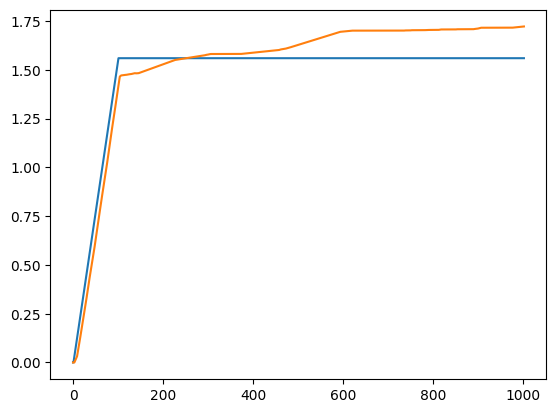

In [25]:
plt.figure()
#plt.plot(X_array.T[2])
plt.plot(X_ideal_array.T[2])
plt.plot(X_real_array.T[2])
plt.show()

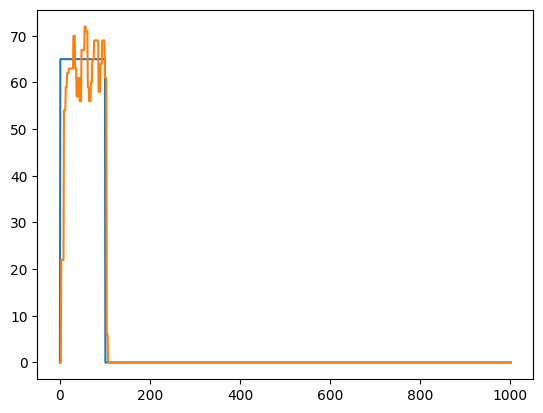

In [26]:
plt.figure()
plt.plot(Ucom_array.T[0])
plt.plot(Usens_array.T[0])
plt.show()

In [27]:
apply_motor_commands(0,0)

# Main code

## Test

In [36]:
# Variables for plotting
X_array = [] # vector state logging over time
Usens_array = []
Ucom_array = []
nav_type_array = [] # navigation type logging over time (-1: local navigation, 0: (global) pure rotation/alignement with waypoint, 1: (global) forwards motion + heading PD)


thymio_start, thymio_theta, goal, polygons_real_world = np.array([0,0]), 0, np.array([0.2,0.2]), np.array([])

# Initial pose measurement (with camera)
X = np.array([thymio_start[0], thymio_start[1], thymio_theta])
P = np.array([[var_x_cam,0,0],[0,var_y_cam,0],[0,0,var_theta_cam]])


# Global navigation and path planning
waypoints = get_objective_waypoints(thymio_start, goal, polygons_real_world)

print(waypoints)

is_aligned = False
is_reached = False
is_locally_navigating = False

state = "GLOBAL"
previous_wall_side = None
prev_error = 0
clearance_counter = 0

while len(waypoints) != 0:
  is_aligned = False
  is_reached = False
  is_locally_navigating = False

  target_waypoint = waypoints.pop()

  v_r, v_l = 0, 0

  counter = 0
  print(counter, " new waypoint")
  while True:
    #print(counter)
    current_time = time.time()

    # X, P = update_robot_pose_EKF(X, P, frame)

    v_r_m, v_l_m = get_motor_speeds()
    U_sens = np.array([v_r_m, v_l_m]).T

    Usens_array.append(U_sens)

    U = np.array([v_r, v_l]).T

    Ucom_array.append(U)

    #print(U_sens)

    X_estim, P_estim = estimate_next_pose(X, P, U_sens, dt) # estimation step

    # xy_cam, theta_cam = get_camera_measurement(frame,only_thymio=True)
    Z_meas = np.array([10, 10, 0]).T

    X, P = correct_estimation(X_estim, P_estim, Z_meas) # correction step -> measurement should be discarded

    X_array.append(X)

    theta_des = np.arctan2(target_waypoint[1]-X[1], target_waypoint[0]-X[0])
    delta_theta = (theta_des - X[2] + np.pi) % (2*np.pi) - np.pi

    distance_to_waypoint = np.sqrt((target_waypoint[0]-X[0])**2 + (target_waypoint[1]-X[1])**2)

    if is_reached:
        break

    if detect_local_obstacle(state):
      is_locally_navigating = True
      print(counter, " is local obstacle detected")

      v_r, v_l = control_local_navigation(state, clearance_counter, previous_wall_side, prev_error)
      apply_motor_commands(v_r,v_l)

      nav_type_array.append(-1)

    else:
      if is_locally_navigating: #if there is no local obstacle anymore but there was one just before (ie the robot just exits local navigation), we stop the bot, recompute the new waypoints and start the inital loop anew
        stop_Thymio()
        waypoints = get_objective_waypoints(X[:2], goal, polygons_real_world)
        break

      elif not is_aligned:
        nav_type_array.append(0)

        if np.abs(delta_theta)>eps_theta:
          if counter%N == 0:
            v_r, v_l = heading_correction_command(X, target_waypoint,N)
            apply_motor_commands(v_r,v_l)

        else:
          print(counter, " is aligned")
          stop_Thymio()
          is_aligned = True
          v_r, v_l = convert_speed_to_tymio_int(forward_speed), convert_speed_to_tymio_int(forward_speed)
          counter = 0

      else:
        nav_type_array.append(1)
        if distance_to_waypoint>eps_d:
          if counter%N == 0:
            del_v_r, del_v_l = heading_correction_command(X, target_waypoint,N)
            apply_motor_commands(int(v_r + del_v_r),int(v_l + del_v_l))

        else:
          stop_Thymio()
          is_reached = True
          print(counter, " is reached")

    counter += 1

    while True:
      if time.time() - current_time >= dt:
        #print(time.time() - current_time)
        break

stop_Thymio()

Shortest distance: 0.28284271247461906
Path indices: [0, 1]
[array([0.2, 0.2])]
0  new waypoint
155  is aligned
561  is reached


In [37]:
X_array = np.array(X_array)
Usens_array = np.array(Usens_array)
Ucom_array = np.array(Ucom_array)
print(X_array.T)

[[0.         0.         0.         ... 0.19155046 0.19197416 0.1923977 ]
 [0.         0.         0.         ... 0.19417721 0.19461047 0.19504388]
 [0.         0.         0.         ... 0.79656    0.79692    0.79728   ]]


In [38]:
X_ideal_array = [X_array[0]]
for i in range(len(Ucom_array)):
    X_ideal_array.append(motion_model(X_ideal_array[-1], convert_thymio_int_to_speed(Ucom_array[i]),dt))
X_ideal_array = np.array(X_ideal_array)

X_real_array = [X_array[0]]
for i in range(len(Usens_array)):
    X_real_array.append(motion_model(X_real_array[-1], convert_thymio_int_to_speed(Usens_array[i]),dt))
X_real_array = np.array(X_real_array)

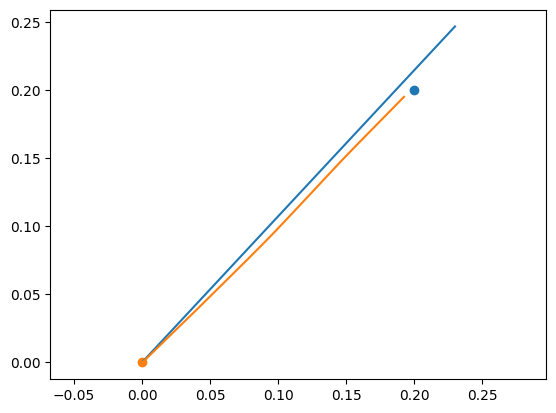

In [39]:
plt.figure()
plt.scatter(goal[0], goal[1])
plt.scatter(thymio_start[0], thymio_start[1])
plt.plot(X_ideal_array.T[0], X_ideal_array.T[1])
plt.plot(X_real_array.T[0], X_real_array.T[1])
plt.axis('equal')
plt.show()

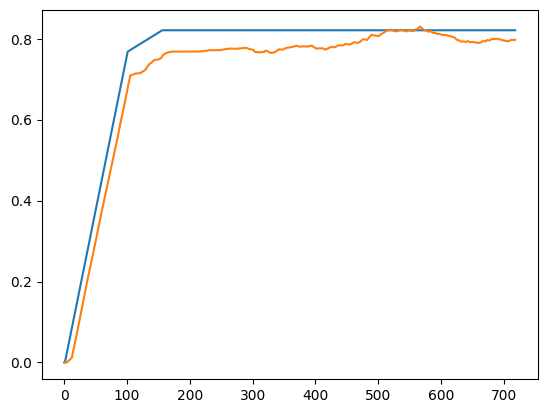

In [40]:
plt.figure()
#plt.plot(X_array.T[2])
plt.plot(X_ideal_array.T[2])
plt.plot(X_real_array.T[2])
plt.show()

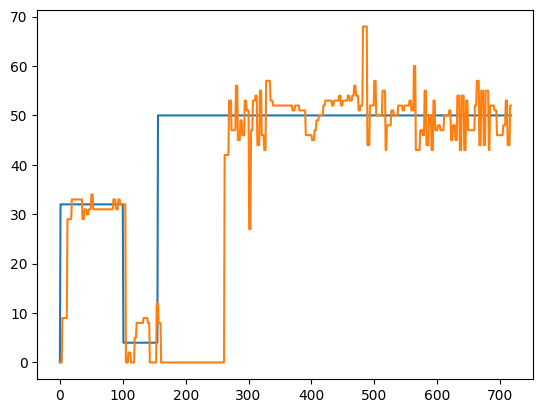

In [41]:
plt.figure()
plt.plot(Ucom_array.T[0])
plt.plot(Usens_array.T[0])
plt.show()

## Main

Unchecked Raise(exc=Call(func=Name(id='ValueError', ctx=Load()), args=[Constant(value='Could not open webcam')], keywords=[]))


AttributeError: module 'cv2.aruco' has no attribute 'detectMarkers'

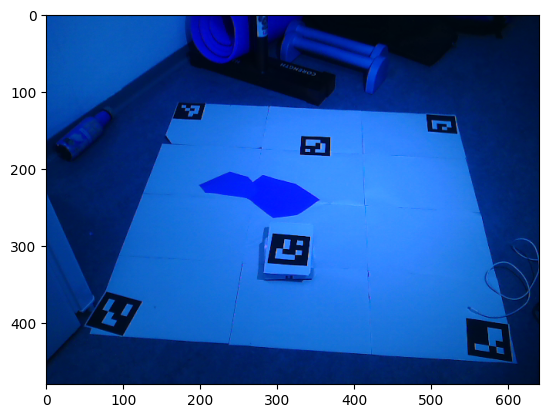

In [41]:
# Variables for plotting
X_array = [] # vector state logging over time
nav_type_array = [] # navigation type logging over time (-1: local navigation, 0: (global) pure rotation/alignement with waypoint, 1: (global) forwards motion + heading PD)

# Open the webcam
cap = cv2.VideoCapture(0)   # /dev/video2

if not cap.isOpened():
    raise ValueError("Could not open webcam")

ret, frame = cap.read()
while not ret:
    print("Can't receive frame. Waiting 1s ...")
    time.sleep(1)
    ret, frame = cap.read()

plt.imshow(frame)
thymio_start, thymio_theta, goal, polygons_real_world, H = get_camera_measurement(frame)

#print(polygons_real_world)
thymio_start, thymio_theta = camera_to_world(frame_size, thymio_start, thymio_theta)
goal, _ = camera_to_world(frame_size, goal, 0)
for i in range(len(polygons_real_world)):
    for j in range(len(polygons_real_world[i])):
        polygon_edge, _ = camera_to_world(frame_size, polygons_real_world[i][j], 0)
        polygons_real_world[i][j][0] = polygon_edge[0]
        polygons_real_world[i][j][1] = polygon_edge[1]
#print(polygons_real_world)


# Initial pose measurement (with camera)
X = np.array([thymio_start[0], thymio_start[1], thymio_theta])
print(X)
P = np.array([[var_x_cam,0,0],[0,var_y_cam,0],[0,0,var_theta_cam]])


# Global navigation and path planning
waypoints = get_objective_waypoints(thymio_start, goal, polygons_real_world)

is_aligned = False
is_reached = False
is_locally_navigating = False

state = "GLOBAL"
previous_wall_side = None
prev_error = 0
clearance_counter = 0

while len(waypoints) != 0:
  is_aligned = False
  is_reached = False
  is_locally_navigating = False

  target_waypoint = waypoints.pop()

  print(target_waypoint)

  v_r, v_l = 0, 0

  counter = 0
  while True:
    current_time = time.time()
    ret, frame = cap.read()
    if not ret:
      print("Didn't receive frame")
    #print(frame)

    X, P = update_robot_pose_EKF(X, P, frame)
    #print(camera_to_world(frame_size,get_camera_measurement(frame,only_thymio=True)[0],get_camera_measurement(frame,only_thymio=True)[1]))
    #print(X)
    X_array.append(X)

    theta_des = np.arctan2(target_waypoint[1]-X[1], target_waypoint[0]-X[0])
    delta_theta = (theta_des - X[2] + np.pi) % (2*np.pi) - np.pi

    distance_to_waypoint = np.sqrt((target_waypoint[0]-X[0])**2 + (target_waypoint[1]-X[1])**2)

    if is_reached:
        break

    if detect_local_obstacle(state):
      is_locally_navigating = True
      print(counter, " is local obstacle detected")

      v_r, v_l = control_local_navigation(state, clearance_counter, previous_wall_side, prev_error)
      apply_motor_commands(v_r,v_l)

      nav_type_array.append(-1)

    else:
      if is_locally_navigating: #if there is no local obstacle anymore but there was one just before (ie the robot just exits local navigation), we stop the bot, recompute the new waypoints and start the inital loop anew
        stop_Thymio()
        waypoints = get_objective_waypoints(X[:2], goal, polygons_real_world)
        break

      elif not is_aligned:
        nav_type_array.append(0)

        if np.abs(delta_theta)>eps_theta:
          if counter%N == 0:
            v_r, v_l = heading_correction_command(X, target_waypoint,N)
            apply_motor_commands(v_r,v_l)

        else:
          print(counter, " is aligned")
          stop_Thymio()
          is_aligned = True
          counter = -1

      else:
        nav_type_array.append(1)
        if distance_to_waypoint>eps_d:
          if counter%N == 0:
            v_r, v_l = convert_speed_to_tymio_int(forward_speed), convert_speed_to_tymio_int(forward_speed)
            del_v_r, del_v_l = heading_correction_command(X, target_waypoint,N)
            apply_motor_commands(int(v_r + del_v_r),int(v_l + del_v_l))

        else:
          stop_Thymio()
          is_reached = True
          print(counter, " is reached")

    counter += 1

    while True:
      if time.time() - current_time >= dt:
        #print(time.time() - current_time)
        break

stop_Thymio()

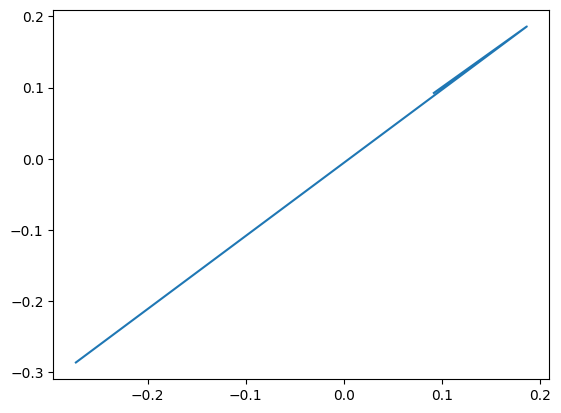

In [33]:
X_array = np.array(X_array).T

plt.figure()
plt.plot(X_array[0],X_array[1])
plt.show()

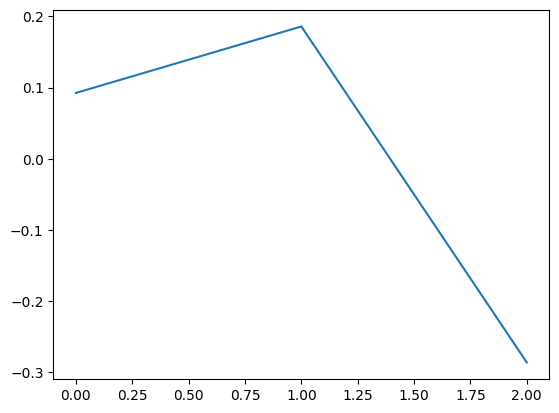

In [34]:
plt.figure()
plt.plot(X_array[2])
plt.show()

In [35]:
stop_Thymio()